# Final Project: Understanding AI Assistant Usage Patterns in Academic Settings

## Group Members
- Issar Manknojiya
- Josh Cini
- Zachary Goodman

## Project Overview
AI assistants such as ChatGPT and other large language models are rapidly becoming embedded in students' day-to-day academic workflows. From drafting essays and debugging code to summarizing readings and preparing for exams, these tools are reshaping how students learn, seek help, and complete assignments.

However, despite their growing presence, there is still limited empirical understanding of *how* students actually interact with AI assistants, what makes a session feel successful or unsuccessful, and which factors drive satisfaction and continued use. Our project addresses this gap by analyzing detailed usage data from student-AI interactions.

## Problem Statement
**Problem Statement: Understanding AI Assistant Usage Patterns in Academic Settings**

Given the rapid adoption of AI assistants in educational environments, there is a critical need to understand usage patterns across different academic contexts. We seek to answer questions such as:
- Which session characteristics are most strongly associated with high student satisfaction?
- How do usage patterns differ by academic level (e.g., undergraduate vs. graduate) and discipline (e.g., STEM vs. humanities)?
- What distinguishes a "successful" AI assistant session from an "unsuccessful" one?

By modeling these patterns, we aim to provide insights that can inform the design of more effective educational technologies and AI-supported learning experiences.

## Dataset
We use the **AI Assistant Usage in Student Life** dataset, which contains **10,000 synthetic student sessions**. Each session captures information such as:
- Academic level and discipline
- Task type (e.g., writing, coding, studying, brainstorming)
- Session length and number of prompts
- Perceived assistance quality and task complexity
- Student satisfaction rating and indicators of session success.

This dataset allows us to explore both individual session characteristics and broader behavioral patterns across many students and contexts.

## Proposed Analysis
Our analysis will focus on three main goals:

1. **Predict student satisfaction ratings**
   - Use session-level features (academic level, discipline, task type, session length, prompt count, etc.) to model and predict satisfaction scores.

2. **Classify successful vs. unsuccessful sessions**
   - Build classification models that distinguish sessions labeled as successful vs. unsuccessful using features such as assistance quality, task complexity, and interaction patterns.

3. **Analyze usage patterns across student groups**
   - Compare usage behaviors across academic disciplines and student levels to identify where AI assistants are most and least effective, and where there may be opportunities for targeted optimization.

## Machine Learning Approach
To address these goals, we plan to implement the following machine learning methods:

- **Supervised Classification Models**
  - Random Forest
  - Support Vector Machine (SVM)
  - Logistic Regression

  These models will be used to predict student satisfaction levels and classify session outcomes (successful vs. unsuccessful). We will evaluate their performance using metrics such as accuracy, precision, recall, F1-score, and confusion matrices.

- **Unsupervised Clustering**
  - K-means clustering
  - Hierarchical clustering

  Clustering will help us discover distinct user behavior segments (e.g., heavy users, quick problem solvers, exploratory learners) based on interaction features and session characteristics.

## Expected Impact
By combining predictive modeling and behavioral clustering, our project aims to:
- Identify the key drivers of positive and negative AI-assisted learning experiences.
- Reveal how usage patterns differ across disciplines and academic levels.
- Provide data-driven recommendations for improving AI assistant design, guidance, and integration into coursework.

Ultimately, these insights could help educators, instructional designers, and AI tool developers better support students in using AI assistants responsibly, effectively, and equitably in academic settings.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.decomposition import PCA

from xgboost import XGBClassifier

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn.utils as utils

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# 1. Data Loading and Exploration

[This Kaggle dataset](https://www.kaggle.com/datasets/ayeshasal89/ai-assistant-usage-in-student-life-synthetic) contains a **synthetic dataset of AI assistant usage in student life**. Each row represents a single AI-assisted academic session and records how a student interacted with an AI tool such as ChatGPT.\n",


#### 1. Loading our Data
Load the train data into a pandas DataFrames. Display the first few rows **of each DataFrame** and print the shape of the dataframe.

In [20]:
file_path = 'ai_assistant_usage_student_life.csv'
df = pd.read_csv(file_path)

#### 2. Checking for Null Values & Shape

Check for null values and shape in the training data.

In [21]:
print("Shape of DataFrame:", df.shape)

df.head()
df.isnull().sum()

Shape of DataFrame: (10000, 11)


SessionID             0
StudentLevel          0
Discipline            0
SessionDate           0
SessionLengthMin      0
TotalPrompts          0
TaskType              0
AI_AssistanceLevel    0
FinalOutcome          0
UsedAgain             0
SatisfactionRating    0
dtype: int64

# 2. Exploratory Data Analysis (EDA)

##### 1. Visualize the Target Variable

First, check if your classes are balanced. If "Assignment Completed" is very rare, your model might struggle (a class imbalance problem).

/var/folders/_s/tww7z6ld4bb42wxgx_ss72hc0000gn/T/ipykernel_31773/1875675265.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='FinalOutcome', data=df, order=df['FinalOutcome'].value_counts().index, palette='viridis')


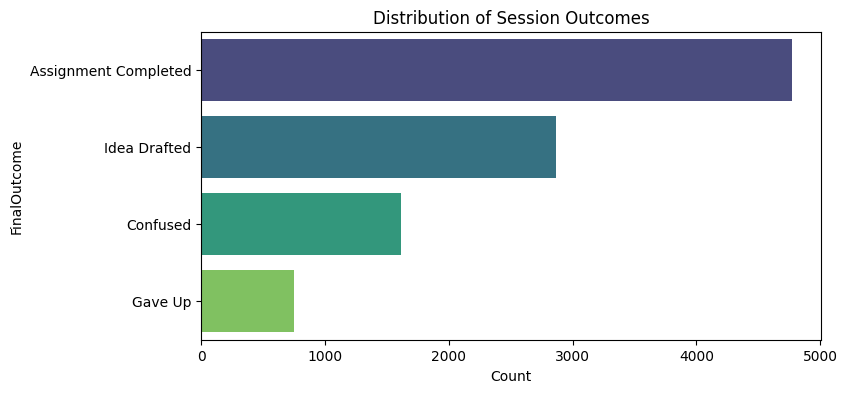

In [22]:
# Check distribution of the raw target variable
plt.figure(figsize=(8, 4))
sns.countplot(y='FinalOutcome', data=df, order=df['FinalOutcome'].value_counts().index, palette='viridis')
plt.title('Distribution of Session Outcomes')
plt.xlabel('Count')
plt.show()

#### 2. Visualize Key Numerical Distributions

Understanding the shape of the data helps decide if we need scaling (StandardScaler) or normalization.

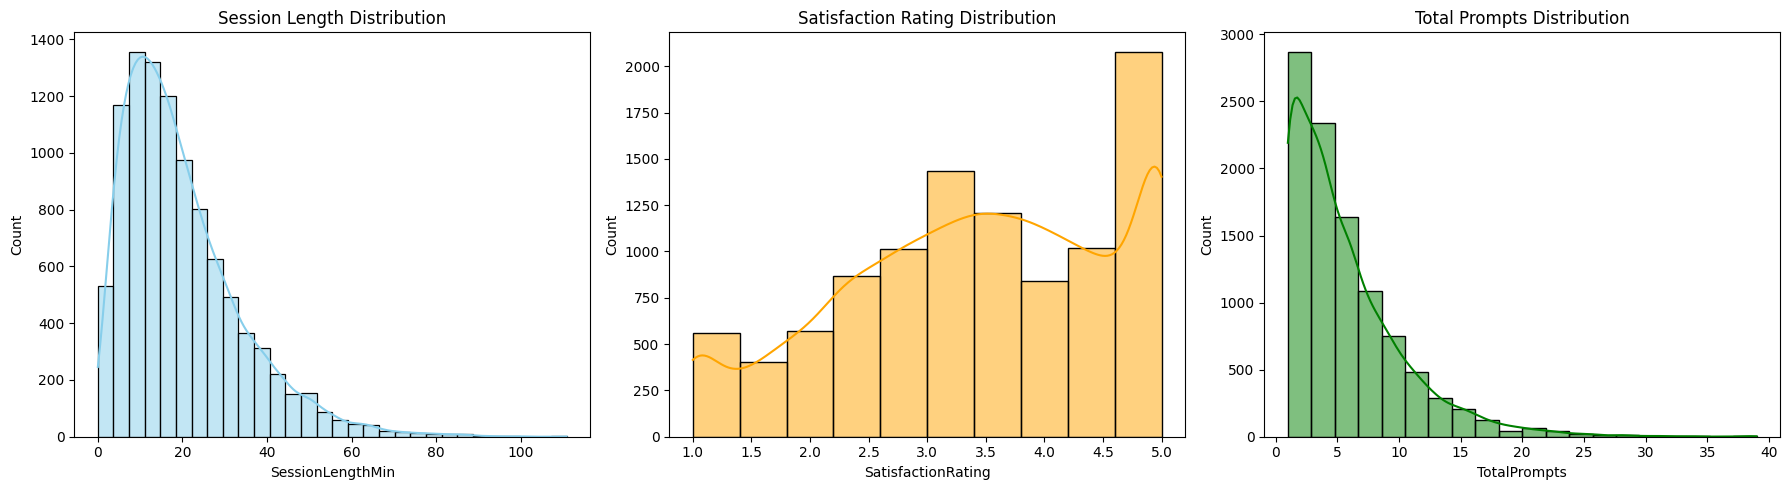

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Session Length
sns.histplot(df['SessionLengthMin'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Session Length Distribution')

# Satisfaction
sns.histplot(df['SatisfactionRating'], bins=10, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Satisfaction Rating Distribution')

# Prompts
sns.histplot(df['TotalPrompts'], bins=20, kde=True, ax=axes[2], color='green')
axes[2].set_title('Total Prompts Distribution')

plt.tight_layout()
plt.show()

#### 3. Correlation Heatmap

This checks for "multicollinearity" (features that are too similar) and sees which features correlate most with Success (IsProductive).

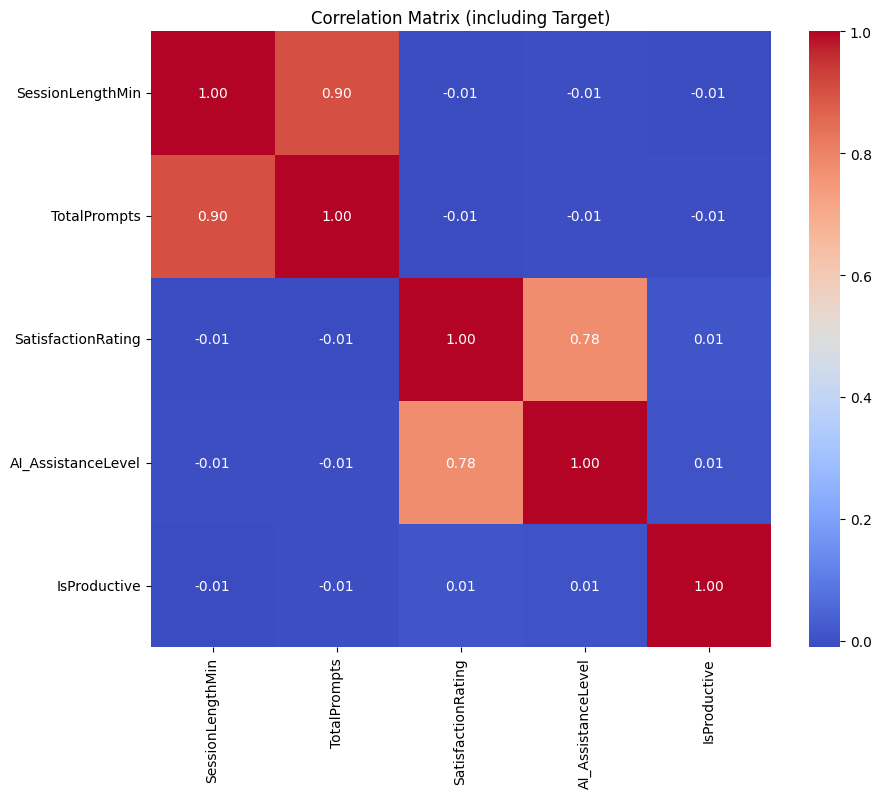

In [24]:
# 1. Light Preprocessing for EDA
# We need to create the target variable NOW so we can visualize it.
# This adds the 'IsProductive' column to your dataframe immediately.
df['IsProductive'] = (df['FinalOutcome'] == 'Assignment Completed').astype(int)

# 2. Select only numerical columns for the heatmap
# We filter the dataframe to only include numbers, or else the correlation function will crash.
numeric_cols = ['SessionLengthMin', 'TotalPrompts', 'SatisfactionRating', 'AI_AssistanceLevel', 'IsProductive']
eda_subset = df[numeric_cols]

# 3. Create the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(eda_subset.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (including Target)')
plt.show()